# Importing Library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
from pandas import read_csv
import datetime
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from datetime import timedelta,date
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import time

In [2]:
df = pd.read_csv('sample_data.csv')
df.t_stamp = pd.to_datetime(df.t_stamp)
df = df.set_index('t_stamp')
df.index.names = ['t_stamp']
df.index = pd.to_datetime(df.index)
df.tail()

,y,Setting_A,Setting_B,Setting_C,Setting_D,Setting_E
t_stamp,,,,,,
2023-05-16 10:28:12.903,72.269610,0.0,0.0,1.0,0.0,0
2023-05-16 10:29:12.907,72.049406,0.0,0.0,1.0,0.0,0
2023-05-16 10:30:12.907,71.645720,0.0,0.0,1.0,0.0,0
2023-05-16 10:31:12.907,71.205344,0.0,0.0,1.0,0.0,0
2023-05-16 10:32:12.907,70.508116,0.0,0.0,1.0,0.0,0


## Get weather data

In [3]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Hourly,Daily
#https://dev.meteostat.net/formats.html#meteorological-data-units
#https://dev.meteostat.net/api/stations/hourly.html#endpoint

# Set time period
start = min(df.index)
end = max(df.index)

# Create Point
location = Point(36.31874, -94.1208)

# Get daily data for 2018
weather_hr = Hourly(location, start, end)
weather_hr = weather_hr.fetch()

weather_d = Daily(location, start, end)
weather_d = weather_d.fetch()

#Date and time statements follow the ISO 8601 standard 
#(e.g. 2016-12-31 for December 31st 2016 and 23:59:58 for 23 hours, 59 minutes, and 58 seconds). 
#The time zone used by Meteostat is Coordinated Universal Time (UTC).
#Coordinated Universal Time is 5 hours ahead of Central Time
weather_hr.index = weather_hr.index - timedelta(hours=5)
#data[data.index == '2023-04-27 14:00:00']

In [4]:
weather_hr = weather_hr[['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco']]
weather_d = weather_d[['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']]

In [5]:
weather_d.rename(columns={i:i+'_d' for i in weather_d.columns}, inplace=True)
weather_hr.rename(columns={i:i+'_hr' for i in weather_hr.columns}, inplace=True)

In [6]:
weather_hr.tail()

,temp_hr,dwpt_hr,rhum_hr,prcp_hr,wdir_hr,wspd_hr,pres_hr,coco_hr
time,,,,,,,,
2023-05-16 01:00:00,20.0,20.0,100.0,0.0,300.0,11.2,1017.5,3.0
2023-05-16 02:00:00,19.0,19.0,100.0,0.3,300.0,9.4,1017.0,7.0
2023-05-16 03:00:00,18.9,18.9,100.0,0.5,290.0,13.0,1016.2,5.0
2023-05-16 04:00:00,17.8,17.8,100.0,0.0,310.0,16.6,1016.2,5.0
2023-05-16 05:00:00,17.2,17.2,100.0,0.3,320.0,11.2,1016.2,5.0


# Data Preparation and Feature Engineering

In [7]:
### remove columns with std == 0 (not changing)
df = df.transpose()[(df.std()!=0)].transpose()

In [8]:
df = pd.merge_asof(df,weather_hr,left_on=df.index, right_on=weather_hr.index).set_index('key_0')
#df = pd.merge_asof(df,weather_d,left_on=df.index, right_on=weather_d.index).set_index('key_0')
df.index.names = ['time']

In [9]:
#temp at decision begin
def value_at_decision_begin(df,list_of_features):
    df['Time_From_Decision_Begin'] = 0
    dates = np.unique([i.strftime('%m/%d/%Y') for i in df.index.date])
    for l in list_of_features:
        df[f'{l}_Decision_Begin'] = 0
        for date in dates:
            for n in range(0,6):
                dt_0 = pd.to_datetime(f"{date} 07:30:00.000") + timedelta(hours=n*2.5)
                dt_1 = dt_0+timedelta(hours=2.5)
                df[f'{l}_Decision_Begin'][dt_0:dt_1] = df[f'{l}'][df.index.get_loc(dt_0, method='nearest')]
    for date in dates:
        for n in range(0,6):
            dt_0 = pd.to_datetime(f"{date} 07:30:00.000") + timedelta(hours=n*2.5)
            dt_1 = dt_0+timedelta(hours=2.5)
            df['Time_From_Decision_Begin'][dt_0:dt_1] = list(range(len(df['Time_From_Decision_Begin'][dt_0:dt_1])))
    
    return df
df = value_at_decision_begin(df,['y'])

In [10]:
def count_continuous_ones(arr):
    l = [0]*len(arr)
    count = 0
    for i in range(1,len(arr)):
        if arr[i-1] == 1 and arr[i] == 1:
            count += 1
            l[i] = count
        else:
            count = 0
            
    return l

In [11]:
df.columns

Index(['y', 'Setting_A', 'Setting_B', 'Setting_C', 'Setting_D', 'Setting_E',
       'temp_hr', 'dwpt_hr', 'rhum_hr', 'prcp_hr', 'wdir_hr', 'wspd_hr',
       'pres_hr', 'coco_hr', 'Time_From_Decision_Begin', 'y_Decision_Begin'],
      dtype='object')

In [12]:
df.Setting_A = count_continuous_ones(list(df.Setting_A))
df.Setting_B = count_continuous_ones(list(df.Setting_B))
df.Setting_C = count_continuous_ones(list(df.Setting_C))
df.Setting_D = count_continuous_ones(list(df.Setting_D))
df.Setting_E = count_continuous_ones(list(df.Setting_E))

In [13]:
timeStart='07:30'
timeEnd='22:30'

df['date'] = df.index.date
df['dayOfWeek'] = df.index.dayofweek
df['hrOfDay'] = df.index.hour
df.dropna(inplace = True)

In [14]:
df = df[(df.dayOfWeek != 5) & 
        (df.dayOfWeek != 6) &
        (df.date != date(2023, 4, 13)) &
        (df.date != date(2023, 4, 17)) &
        (df.date != date(2023, 4, 22)) &
        (df.date != date(2023, 4, 29)) &
        (df.date != date(2023, 5, 6)) &
        (df.date != date(2023, 5, 7)) &

        (df.date != date(2023, 5, 13)) &
        (df.date != date(2023, 5, 14)) &

        (df.date != date(2023, 5, 19)) &
        (df.date != date(2023, 5, 20)) &
        (df.date != date(2023, 5, 21)) &

        (df.date != date(2023, 5, 27)) &
        (df.date != date(2023, 5, 28)) &
        (df.date != date(2023, 5, 29)) &
        (df.date != date(2023, 6, 3)) &
        (df.date != date(2023, 6, 4)) &
        (df.date != date(2023, 6, 5)) &

        (df.date != date(2023, 6, 10)) &
        (df.date != date(2023, 6, 11)) &   
        (df.date != date(2023, 6, 20)) &

     (df.date < date(2023, 7, 1))]

df = df.between_time(timeStart, timeEnd)

In [15]:
s = df.groupby(['date']).std().Setting_A < 6
print(s[s].index)
df = df[~df['date'].isin(s[s].index)]

Index([2023-05-16], dtype='object', name='date')


In [16]:
df.columns

Index(['y', 'Setting_A', 'Setting_B', 'Setting_C', 'Setting_D', 'Setting_E',
       'temp_hr', 'dwpt_hr', 'rhum_hr', 'prcp_hr', 'wdir_hr', 'wspd_hr',
       'pres_hr', 'coco_hr', 'Time_From_Decision_Begin', 'y_Decision_Begin',
       'date', 'dayOfWeek', 'hrOfDay'],
      dtype='object')

In [17]:
df

,y,Setting_A,Setting_B,Setting_C,Setting_D,Setting_E,temp_hr,dwpt_hr,rhum_hr,prcp_hr,wdir_hr,wspd_hr,pres_hr,coco_hr,Time_From_Decision_Begin,y_Decision_Begin,date,dayOfWeek,hrOfDay
time,,,,,,,,,,,,,,,,,,,
2023-04-14 07:30:56.290,61.676157,0,0,0,0,0,13.9,8.3,69.0,0.0,150.0,7.6,1008.5,1.0,0.0,61.639594,2023-04-14,4,7
2023-04-14 07:31:56.290,61.420142,0,0,1,0,0,13.9,8.3,69.0,0.0,150.0,7.6,1008.5,1.0,1.0,61.639594,2023-04-14,4,7
2023-04-14 07:32:56.293,61.127535,0,0,2,0,0,13.9,8.3,69.0,0.0,150.0,7.6,1008.5,1.0,2.0,61.639594,2023-04-14,4,7
2023-04-14 07:33:56.297,61.200663,0,0,3,0,0,13.9,8.3,69.0,0.0,150.0,7.6,1008.5,1.0,3.0,61.639594,2023-04-14,4,7
2023-04-14 07:34:56.297,61.383578,0,0,4,0,0,13.9,8.3,69.0,0.0,150.0,7.6,1008.5,1.0,4.0,61.639594,2023-04-14,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15 22:27:36.277,75.021910,0,0,0,0,15,20.0,20.0,100.0,0.0,290.0,5.4,1018.3,3.0,153.0,73.260413,2023-05-15,0,22
2023-05-15 22:28:11.697,75.058592,0,0,0,0,16,20.0,20.0,100.0,0.0,290.0,5.4,1018.3,3.0,154.0,73.260413,2023-05-15,0,22
2023-05-15 22:28:36.277,75.058592,0,0,0,0,17,20.0,20.0,100.0,0.0,290.0,5.4,1018.3,3.0,155.0,73.260413,2023-05-15,0,22


In [18]:
df = df[[
        #Target:
        'y',
        
        #Decision:
        'Setting_A', 'Setting_B', 'Setting_C','Setting_D', 'Setting_E',
        
        #Environment:
        'y_Decision_Begin',
        'Time_From_Decision_Begin',
        'hrOfDay',
        'dayOfWeek', 
        
        #Weather:
        'pres_hr','temp_hr', 'prcp_hr', 'wdir_hr', 'wspd_hr', 'dwpt_hr', 'coco_hr',
        #ignore because high correlation with othe features
        #'rhum_hr',
        ]]

# Descriptive Analytics (Data Visualization)

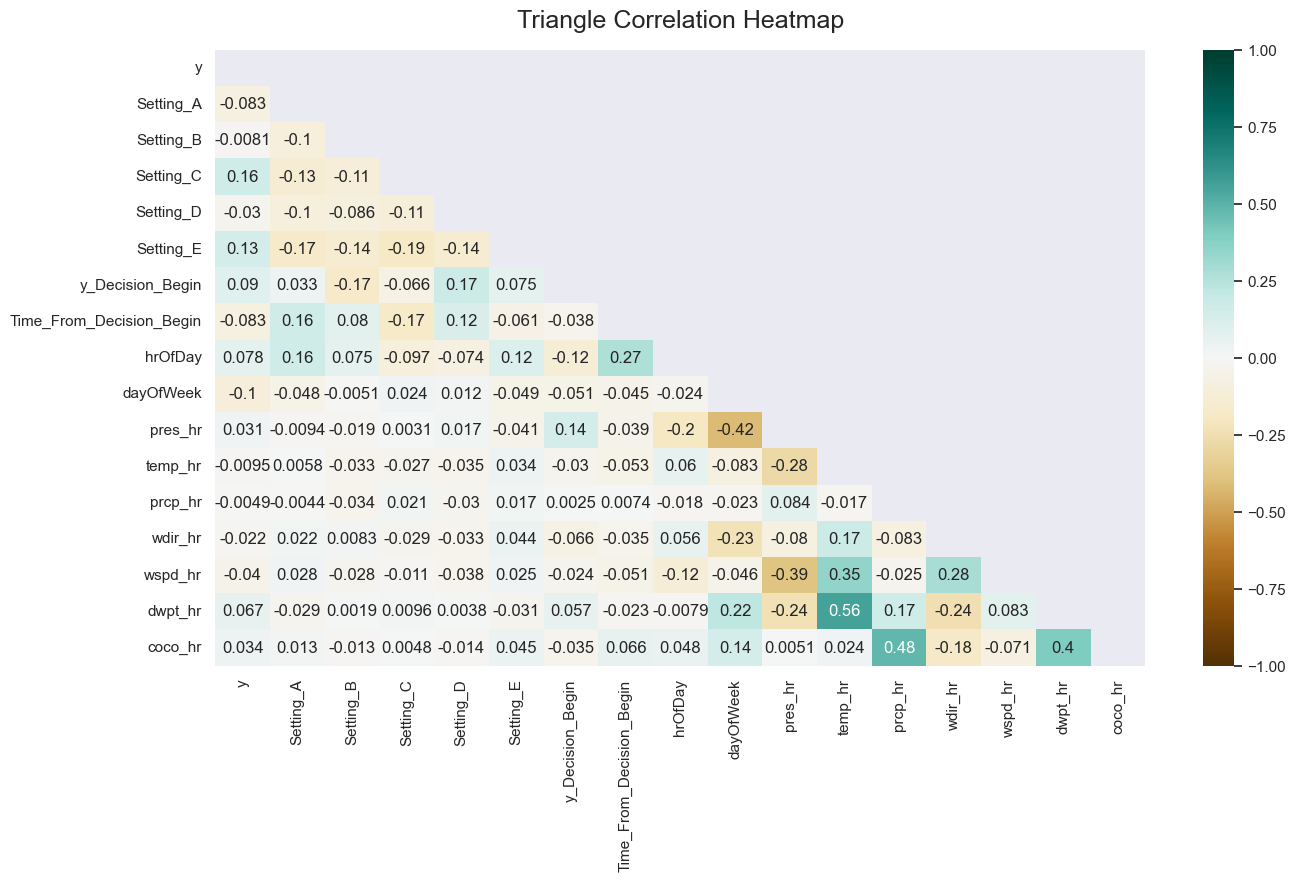

In [19]:
#Correlation Map for numeric variables:
# define the mask to set the values in the upper triangle to True
sns.set(rc = {'figure.figsize':(15,8)})

mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

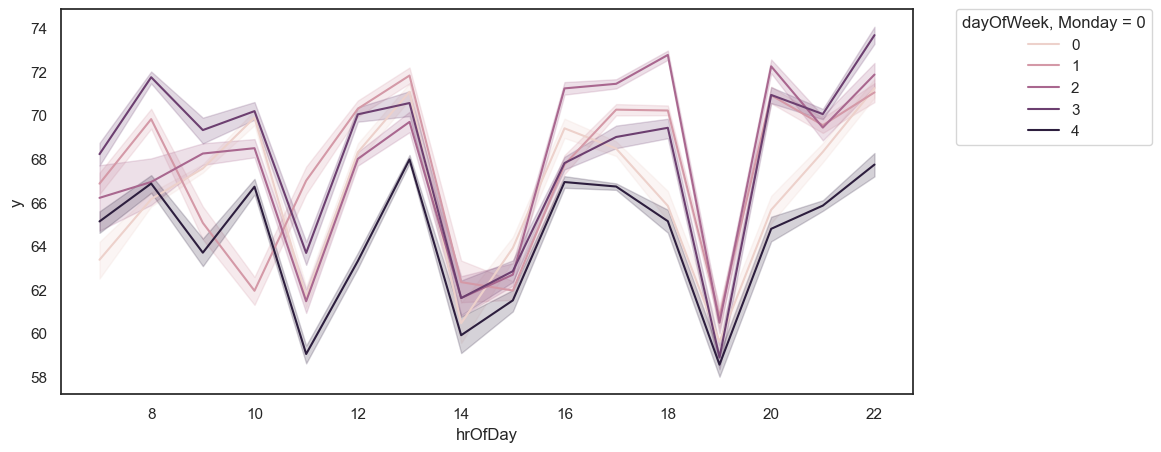

In [20]:
sns.set(rc={'figure.figsize':(11,5)})
sns.set_theme(style="white", palette=None)

sns.lineplot(data=df, x='hrOfDay', y="y", hue="dayOfWeek")
plt.legend(bbox_to_anchor=(1.05, 1),  title = 'dayOfWeek, Monday = 0',loc=2, borderaxespad=0.)

In [21]:
df.columns

Index(['y', 'Setting_A', 'Setting_B', 'Setting_C', 'Setting_D', 'Setting_E',
       'y_Decision_Begin', 'Time_From_Decision_Begin', 'hrOfDay', 'dayOfWeek',
       'pres_hr', 'temp_hr', 'prcp_hr', 'wdir_hr', 'wspd_hr', 'dwpt_hr',
       'coco_hr'],
      dtype='object')

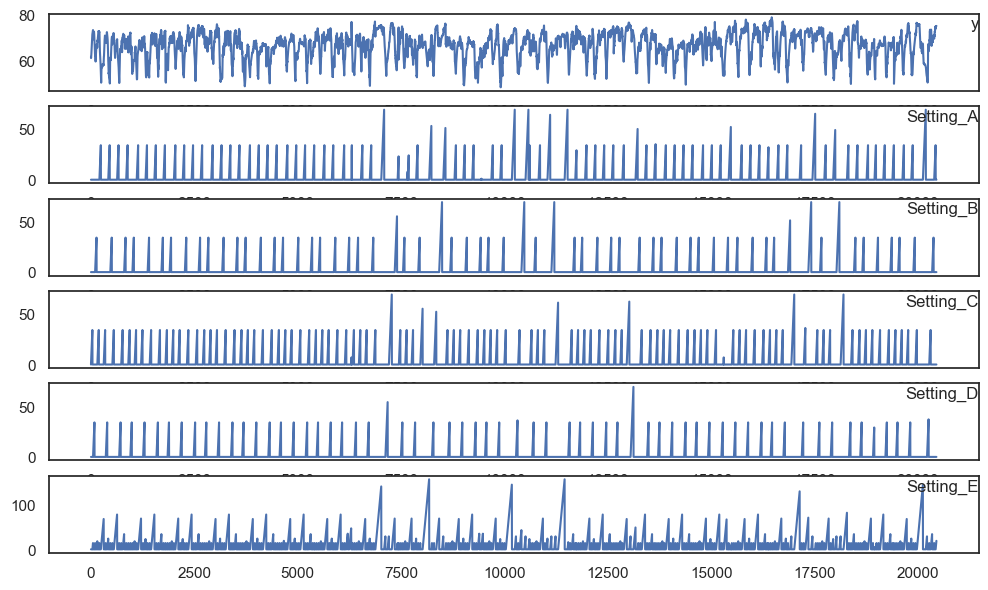

In [22]:
values = df.values
# specify columns to plot
#3,5
groups = [0,1,2,3,4,5]
i = 1
# plot each column
pyplot.figure(figsize=(12,7))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=
                 0.7, loc='right',size = 12)
    i += 1

pyplot.show()

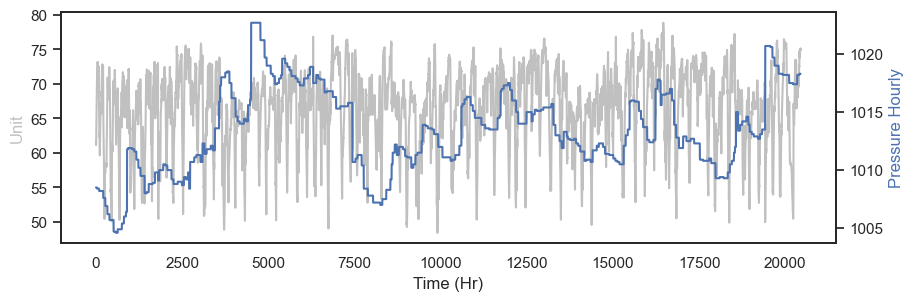

In [23]:
sns.set(rc={'figure.figsize':(10,3)})
sns.set_style("white")
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  

y1 = list(df["y"])
y2 = list(df["pres_hr"])

        
ax1.plot(y1, 'silver')
ax2.plot(y2, 'b-')

ax1.set_xlabel('Time (Hr)')
ax1.set_ylabel('Unit', color='silver')
ax2.set_ylabel('Pressure Hourly', color='b')

plt.show()


# Predictive Analytics (XGBOOST)

In [24]:
df.dropna(inplace = True)

In [25]:
y = df['y']
X = df.drop(columns=['y'])

In [26]:
df.shape

(20443, 17)

In [27]:
#split the data based on the date
split_date="05-09-2023"
X_train=X.loc[X.index <=split_date].copy()
y_train=y.loc[y.index <=split_date].copy()
X_test=X.loc[X.index >split_date].copy()
y_test=y.loc[y.index >split_date].copy()

In [28]:
X_test_orig=X.loc[X.index >split_date].copy()

In [29]:
mm = MinMaxScaler()
X_train[X_train.columns] = mm.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = mm.transform(X_test[X_test.columns])

In [30]:
X_test.columns

Index(['Setting_A', 'Setting_B', 'Setting_C', 'Setting_D', 'Setting_E',
       'y_Decision_Begin', 'Time_From_Decision_Begin', 'hrOfDay', 'dayOfWeek',
       'pres_hr', 'temp_hr', 'prcp_hr', 'wdir_hr', 'wspd_hr', 'dwpt_hr',
       'coco_hr'],
      dtype='object')

### Hyperparam Tuning XGboost

In [31]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
#Import 'scope' from hyperopt in order to 
#obtain int values for certain hyperparameters.
from hyperopt.pyll.base import scope
hyperparameter_grid={'max_depth': scope.int(hp.quniform("max_depth", 1, 15, 1)),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 1000,
        'eta': hp.uniform('eta', 0,1),            
        'seed': 0
    }

In [32]:
def objective(space):
    model = xgb.XGBRegressor(**space, early_stopping_rounds=100,  eval_metric="rmse")
    #Define evaluation datasets.
    evaluation = [(X_train, y_train), (X_test, y_test)]
    #Fit the model. 
    model.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)
    pred = model.predict(X_test)
    mse= mean_squared_error(y_test, pred)
    print ("SCORE:", mse)
    return {'loss':mse, 'status': STATUS_OK, 'model': model}

In [33]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = hyperparameter_grid,
                        algo = tpe.suggest,
                        max_evals = 25,
                        trials = trials)

SCORE:                                                                                                                 
20.857852175324506                                                                                                     
SCORE:                                                                                                                 
22.511507897625815                                                                                                     
SCORE:                                                                                                                 
22.879088588352914                                                                                                     
SCORE:                                                                                                                 
22.576867891431437                                                                                                     
SCORE:                                  

In [34]:
best_model = trials.results[np.argmin([r['loss'] for r in 
    trials.results])]['model']
lowest_loss = trials.results[np.argmin([r['loss'] for r in 
    trials.results])]['loss']
print(best_model, lowest_loss)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=100,
             enable_categorical=False, eta=0.34475664212199275,
             eval_metric='rmse', feature_types=None, gamma=4.959606236218268,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1.0, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...) 19.511341213916783


In [35]:
xgb_tuned=xgb.XGBRegressor(
                    max_dept=int(best_hyperparams['max_depth']),
                    #colsample_bytree=best_hyperparams['colsample_bytree'],
                    objective='reg:squarederror',
                    tree_method='hist',
                    eval_metrics='rmse',
                    eta=best_hyperparams['eta'],
                    gamma=best_hyperparams['gamma'],
                    min_child_weight=best_hyperparams['min_child_weight'],
                    early_stopping_rounds=500,
                    n_estimators=1000,
)
xgb_tuned.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=50)

[08:21:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "eval_metrics", "max_dept" } are not used.

[0]	validation_0-rmse:43.42174	validation_1-rmse:44.57738
[50]	validation_0-rmse:1.09785	validation_1-rmse:4.41718
[100]	validation_0-rmse:1.09785	validation_1-rmse:4.41719
[150]	validation_0-rmse:1.09785	validation_1-rmse:4.41719
[200]	validation_0-rmse:1.09785	validation_1-rmse:4.41719
[250]	validation_0-rmse:1.09785	validation_1-rmse:4.41719
[300]	validation_0-rmse:1.09785	validation_1-rmse:4.41719
[350]	validation_0-rmse:1.09785	validation_1-rmse:4.41719
[400]	validation_0-rmse:1.09785	validation_1-rmse:4.41719
[450]	validation_0-rmse:1.09785	validation_1-rmse:4.41719
[500]	validation_0-rmse:1.09785	validation_1-rmse:4.41719
[518]	validation_0-rmse:1.09785	validation_1-rmse:4.41719


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=500,
             enable_categorical=False, eta=0.34475664212199275,
             eval_metric=None, eval_metrics='rmse', feature_types=None,
             gamma=4.959606236218268, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_dept=4,
             max_depth=None, max_leaves=None, min_child_weight=1.0, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None, ...)

### Feature Importance

Text(0.5, 0, 'Xgboost Feature Importance')

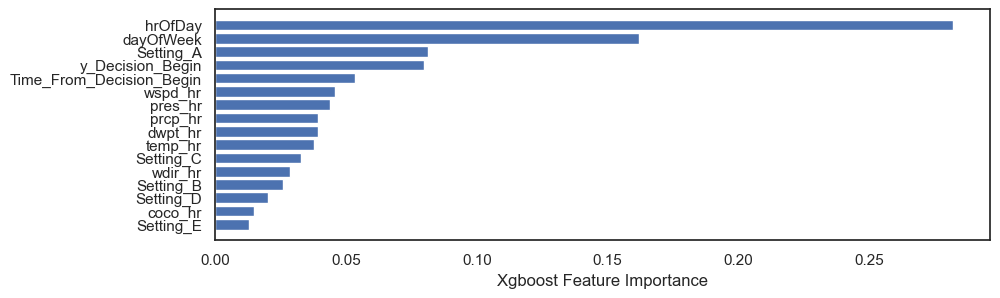

In [36]:
#clrs = ['red' if (x<288) and (x>100) else 'grey' for x in ]
#_=plot_importance(xgb_tuned, height=0.9) #F-Score

#Information Gain:
#Reference: https://mljar.com/blog/feature-importance-xgboost/
sorted_idx = xgb_tuned.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb_tuned.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance") 

### Results and Visualization

In [37]:
xgb_preds = xgb_tuned.predict(X_test)
xgb_score = mean_squared_error(y_test, xgb_preds, squared=False)
print('RMSE_Best_Model:', xgb_score)

RMSE_Best_Model: 4.327715438690377


In [38]:
from sklearn.metrics import r2_score
r2_score(y_test, xgb_preds)

0.49292185381033915

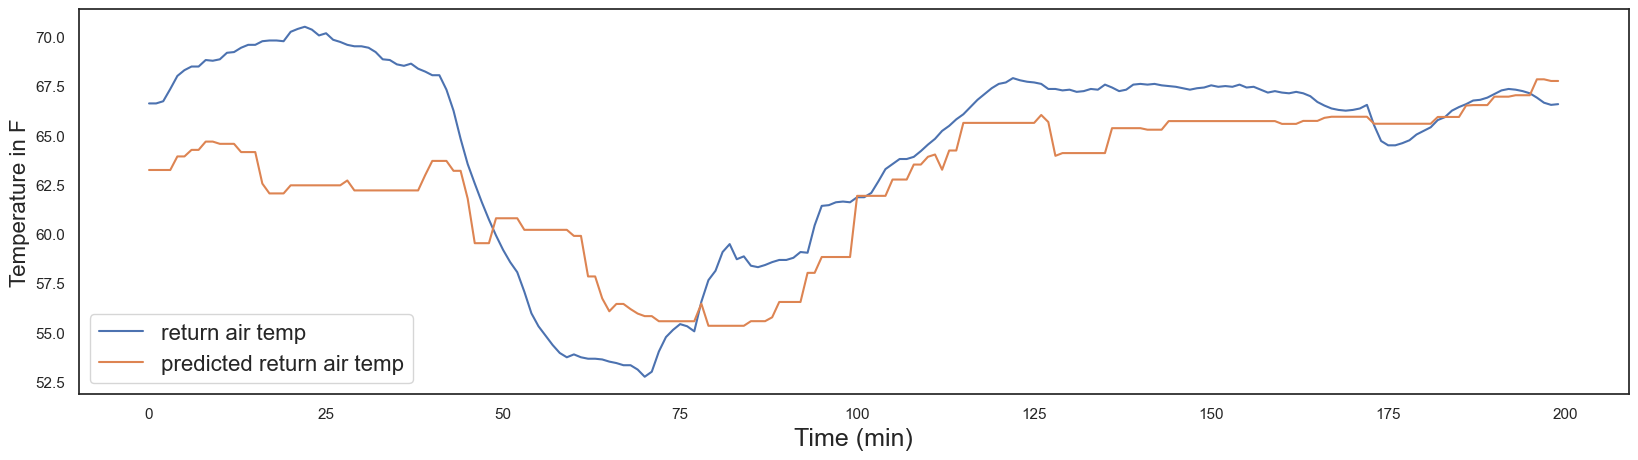

In [39]:
from random import randint
sns.set_style("white")
i = randint(0,len(y_test)-200)

pyplot.figure(figsize=(20,5))
pyplot.plot(list(y_test)[i:i+200], label='return air temp')
pyplot.plot(xgb_preds[i:i+200], label='predicted return air temp')
plt.xlabel('Time (min)', fontsize=18)
plt.ylabel('Temperature in F', fontsize=16)
plt.rc('legend', fontsize = 16)
pyplot.legend()
pyplot.show()

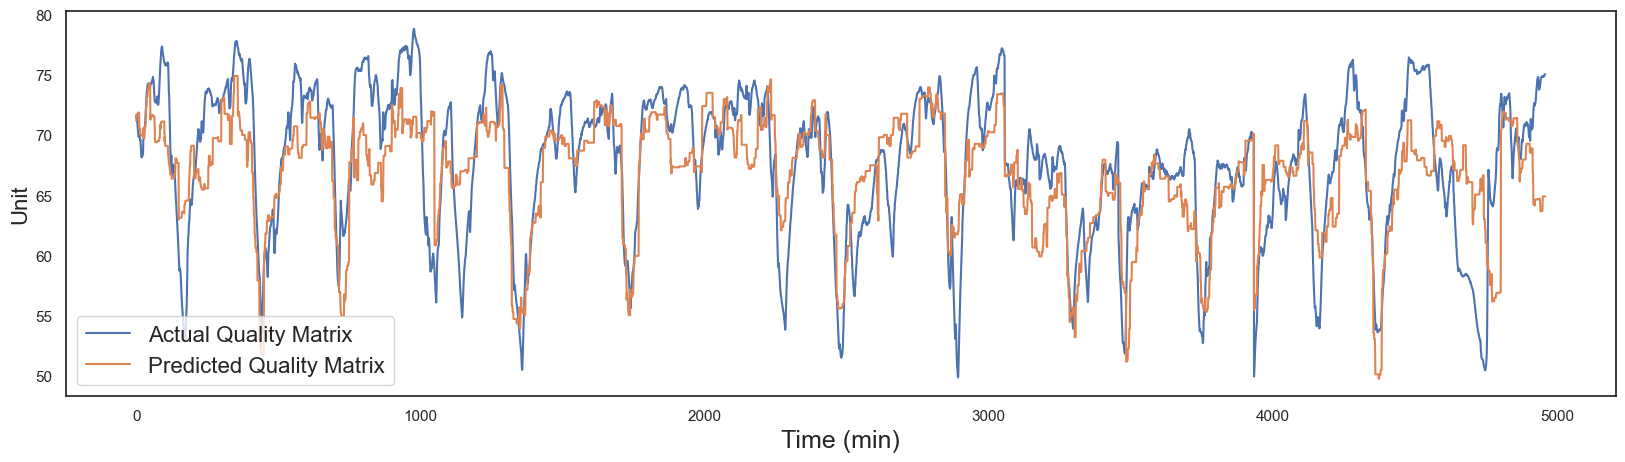

In [40]:
from random import randint
sns.set_style("white")

pyplot.figure(figsize=(20,5))
pyplot.plot(list(y_test)[0:-1], label='Actual Quality Matrix')
pyplot.plot(xgb_preds[0:-1], label='Predicted Quality Matrix')
plt.xlabel('Time (min)', fontsize=18)
plt.ylabel('Unit', fontsize=16)
plt.rc('legend', fontsize = 16)
pyplot.legend()
pyplot.show()

# Prescriptive Analytics (Integer Programming)

In [41]:
def end_defrost_temp(i):
    # this function find the instruction and transformed to the way prediciton model wants to see. 
    n=int(np.argmax(i[0:5]))
    timer = i[5]
    mx = np.array([list(i)]*timer)
    mx[:, n] = [j for j in range(0,timer)]
    mx = np.delete(mx, 5, 1)
    mx = mm.transform(mx)
    xgb_preds = xgb_tuned.predict(mx)
    e = mean_squared_error([TARGET_TEMP]*len(xgb_preds), xgb_preds, squared=True)
    return xgb_preds[-1],xgb_preds,e

In [42]:
def arc_cost(s):
    costs = {}
    temps = {}
    for (i,j) in s:
        costs[(i,j)] = resources_err[i]
        temps[(i,j)] = resources_temp_list[i]
    return costs,temps

In [43]:
decisions = [[1., 0., 0., 0., 0., 35],
             [0., 1., 0., 0., 0., 35],
             [0., 0., 1., 0., 0., 35],
             [0., 0., 0., 1., 0., 35],
             [0., 0., 0., 0., 1.,  5],
             [0., 0., 0., 0., 1., 10],
             [0., 0., 0., 0., 1., 20]]

In [44]:
dates = np.unique([i.strftime('%m/%d/%Y') for i in X_test.index.date])
#dates = ['2023-05-09']
TARGET_TEMP = 67
number_of_time_split = 7

solutions = {}
dd = 0 #unique id for each generated node
for date in dates:
    dt_0 = pd.to_datetime(f"{date} 07:30:00.000")
    while dt_0 < pd.to_datetime(f"{date} 22:30:00.000"):
        ############## Create Network Flow Structure ###############
        start = time.time()
        print(f'Working on {dt_0}:')
        print('Creating network...')
        # This is the starting node for each batch of optimization network. The node starts with index 5 to include present tempreture.
        node_0 = X_test_orig.iloc[X_test_orig.index.get_loc(dt_0, method='nearest')][5:]
        if dt_0 == pd.to_datetime(f"{date} 07:30:00.000"):
            #Assume use setting A first everyday, which is (1,0,0,0,0....), dd is unique id for each generated node
            node_0 = [tuple(list(decisions[0])+list(node_0)+[dd])]
            dd = dd+1
        else:
            # If not first node of that day that means we need to use previous solution's last node, which will always end with the word sink.
            decision_prev = [row.origin for row in Network.itertuples() if row.select.solution_value == 1 and row.destination == 'sink']
            n=int(np.argmax(decision_prev[0][0:5]))
            node_0 = [tuple(list(decisions[n])+list(node_0)+[dd])]
            dd = dd+1
            
        # The following code is to generate time interval, right now it's hard code to look ahead 2.5 hours, which means we need 5 x 30mins intervals
        nodes_arr = [node_0]
        dt_arr = [dt_0]
        for i in range(1,number_of_time_split):
            dt_arr.append(dt_arr[i-1] + timedelta(hours=0.5))
            nodes_arr.append(X_test_orig.iloc[X_test_orig.index.get_loc(dt_arr[i], method='nearest')][6:])           

            
        # This part connects the nodes in a dictionary form: The key is the origin node and the values in the dict are what the origin connects to. 
        node_dict_arr = []
        resources_temp_list = {}
        resources_err = {}

        def _update_node_dict(node_dict_arr, resources_temp_list, resources_err, idx, node, dd):
            lst_temp, temp_list, err = end_defrost_temp(node[:-1])
            node_dict_arr[idx][node] = [tuple(list(i)+[lst_temp]+list(nodes_arr[idx])+[dd]) for i in decisions]
            
            resources_temp_list[node] = temp_list 
            resources_err[node] = err
            dd = dd+1
            return node_dict_arr, resources_temp_list, resources_err, dd

        # Create values for node 2 - node number_of_time_split
        for p in range(number_of_time_split):
            node_dict_arr.append({})
            if p == 1:
                print('Updating node dict... 0 ')
                node_dict_arr, resources_temp_list, resources_err, dd = _update_node_dict(
                    node_dict_arr=node_dict_arr, 
                    resources_temp_list=resources_temp_list, 
                    resources_err=resources_err,idx=p, node=node_0[0], dd=dd)
            elif p >= 2:
                for key in node_dict_arr[p-1].keys():
                    #print('current Key: ', key)
                    for idx, n in enumerate(node_dict_arr[p-1][key]):
                        node_dict_arr, resources_temp_list, resources_err, dd = _update_node_dict(
                            node_dict_arr=node_dict_arr, 
                            resources_temp_list=resources_temp_list, 
                            resources_err=resources_err,idx=p, node=n, dd=dd)

        # Unpacking dict into list of Arcs. 
        s_values = []
        #print('len of node dict: ', node_dict_arr[1:-1])
        for node_dict in node_dict_arr[:-1]:
            s_values.append([(i,j) for i in node_dict.keys() for j in node_dict[i]])

        s_values.append([(j,'sink') for (i,j) in s_values[-1]])

        Arcs = set()
        s_sum = []
        for s in s_values:
            s_sum += s
        
        Arcs = set(s_sum)
        
        print('Almost there..')
        Arcs_cost, Arcs_temp = arc_cost(Arcs)

        end = time.time()
        print(f'Boom! Number of arcs generated is {len(Arcs_cost)}, total time spent creating arcs is {round(end-start)} s')

        
        ############## Define Objective ###############
        from docplex.mp.model import Model
        mdl = Model()
        mdl.clear_constraints()
        mdl.remove_objective()
        
        start = time.time()
        print('Setting network flow objectives')

        all = []
        for i in Arcs_cost:
            all.append([i[0],i[1],Arcs_cost[i]])
        Network = pd.DataFrame(all, columns = ['origin','destination','cost'])

        Network['select'] = 0

        for row in Network.itertuples():
            dv = mdl.binary_var(name=f'select_{row.origin}_{row.destination}')
            Network['select'].loc[row.Index]= dv

        #objective:
        mdl.minimize(mdl.sum(Network.cost * Network.select))
        end = time.time()
        print(f'Total time creating variable and defining objective is {round(end - start,3)} s')
        
        ############## Add Flow Conservation Constraints ###############
        start = time.time()
        print('Adding flow conservation constraints..')

        Outgoing_Flow = Network[['origin','select']].groupby('origin').agg(sum).reset_index().rename(columns = {'select':"outgoing_Flow"})
        Incoming_Flow = Network[['destination','select']].groupby('destination').agg(sum).reset_index().rename(columns = {'select':"incoming_Flow"})
        Inflow_Outflow = pd.merge(Incoming_Flow, Outgoing_Flow, left_on='destination', right_on = 'origin', how = 'outer')

        Inflow_Outflow['supply'] = 0
        Inflow_Outflow['supply'].loc[Inflow_Outflow.destination=='sink'] = 1
        Inflow_Outflow['supply'].loc[Inflow_Outflow.origin == node_0[0]] = -1

        Inflow_Outflow = Inflow_Outflow.fillna(0)
        for row in Inflow_Outflow.itertuples():
            mdl.add_constraint( row.incoming_Flow - row.outgoing_Flow  == row.supply)

        end = time.time()
        print(f'Total time adding flow conservation constraints is {round(end - start,3)} s')
    
        ############## Add Node Specific Constraints ###############
        print('Adding node contraints...')
        start = time.time()
        # Adding constraints: Each setting use at least once in the current period or the last. 
        # If time is the beginning of the day, don't look for last period:
        if dt_0 == pd.to_datetime(f"{date} 07:30:00.000"):
            for w in range(0,4):
                mdl.add_constraint(mdl.sum(row.select * row.origin[w] for row in Network.itertuples()) <= 2)
            mdl.add_constraint(mdl.sum(row.select * row.origin[5] for row in Network.itertuples()) == 150)
        else:
            previous_time = dt_0 - timedelta(hours=2.5)
            previous_time_sol = [i[:6] for (i,j) in list(solutions[previous_time].keys())]
            previous_time_sol = np.array([list(i) for i in previous_time_sol]).sum(axis = 0)
            previous_time_sol = [int(i) for i in previous_time_sol]
            for w in range(0,4):
                mdl.add_constraint(mdl.sum(row.select * row.origin[w] for row in Network.itertuples()) + previous_time_sol[w] >= 1)
                mdl.add_constraint(mdl.sum(row.select * row.origin[w] for row in Network.itertuples()) <= 2)
            mdl.add_constraint(mdl.sum(row.select * row.origin[5] for row in Network.itertuples()) + previous_time_sol[5] >= 280)
            mdl.add_constraint(mdl.sum(row.select * row.origin[5] for row in Network.itertuples()) + previous_time_sol[5] <= 320)
        end = time.time()
        print(f'Total time adding node constraints is {round(end - start,3)} s')

        ############## Solve ###############

        print('Solving...')
        mdl.solve()
        print(f'Solved...')
        print(mdl.get_solve_details())
        solutions[dt_0] = {(row.origin,row.destination):Arcs_temp[(row.origin,row.destination)] for row in Network.itertuples() if row.select.solution_value == 1}
        #set initial time of the next optimization period
        dt_0 = dt_0 + timedelta(hours=2.5)

Working on 2023-05-09 07:30:00:
Creating network...
Updating node dict... 0 
Almost there..
Boom! Number of arcs generated is 36414, total time spent creating arcs is 13 s
Setting network flow objectives
Total time creating variable and defining objective is 2.633 s
Adding flow conservation constraints..
Total time adding flow conservation constraints is 3.009 s
Adding node contraints...
Total time adding node constraints is 0.401 s
Solving...
Solved...
status  = integer optimal solution
time    = 2.329 s.
problem = MILP
gap     = 0%

Working on 2023-05-09 10:00:00:
Creating network...
Updating node dict... 0 
Almost there..
Boom! Number of arcs generated is 36414, total time spent creating arcs is 14 s
Setting network flow objectives
Total time creating variable and defining objective is 2.729 s
Adding flow conservation constraints..
Total time adding flow conservation constraints is 2.822 s
Adding node contraints...
Total time adding node constraints is 0.8 s
Solving...
Solved...
sta

Setting network flow objectives
Total time creating variable and defining objective is 2.773 s
Adding flow conservation constraints..
Total time adding flow conservation constraints is 3.082 s
Adding node contraints...
Total time adding node constraints is 0.804 s
Solving...
Solved...
status  = integer optimal solution
time    = 4.203 s.
problem = MILP
gap     = 0%

Working on 2023-05-11 17:30:00:
Creating network...
Updating node dict... 0 
Almost there..
Boom! Number of arcs generated is 36414, total time spent creating arcs is 13 s
Setting network flow objectives
Total time creating variable and defining objective is 2.716 s
Adding flow conservation constraints..
Total time adding flow conservation constraints is 2.932 s
Adding node contraints...
Total time adding node constraints is 0.792 s
Solving...
Solved...
status  = integer optimal solution
time    = 4.312 s.
problem = MILP
gap     = 0%

Working on 2023-05-11 20:00:00:
Creating network...
Updating node dict... 0 
Almost there.

In [45]:
X_test_orig

,Setting_A,Setting_B,Setting_C,Setting_D,Setting_E,y_Decision_Begin,Time_From_Decision_Begin,hrOfDay,dayOfWeek,pres_hr,temp_hr,prcp_hr,wdir_hr,wspd_hr,dwpt_hr,coco_hr
time,,,,,,,,,,,,,,,,
2023-05-09 07:30:03.810,0,0,0,0,0,71.498919,0.0,7,1,1015.9,20.0,0.0,100.0,13.0,19.3,5.0
2023-05-09 07:31:03.810,0,0,0,0,1,71.498919,1.0,7,1,1015.9,20.0,0.0,100.0,13.0,19.3,5.0
2023-05-09 07:32:03.813,0,0,0,0,2,71.498919,2.0,7,1,1015.9,20.0,0.0,100.0,13.0,19.3,5.0
2023-05-09 07:33:03.813,0,0,0,0,3,71.498919,3.0,7,1,1015.9,20.0,0.0,100.0,13.0,19.3,5.0
2023-05-09 07:34:03.817,0,0,0,0,4,71.498919,4.0,7,1,1015.9,20.0,0.0,100.0,13.0,19.3,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15 22:27:36.277,0,0,0,0,15,73.260413,153.0,22,0,1018.3,20.0,0.0,290.0,5.4,20.0,3.0
2023-05-15 22:28:11.697,0,0,0,0,16,73.260413,154.0,22,0,1018.3,20.0,0.0,290.0,5.4,20.0,3.0
2023-05-15 22:28:36.277,0,0,0,0,17,73.260413,155.0,22,0,1018.3,20.0,0.0,290.0,5.4,20.0,3.0


In [46]:
previous_time_sol

[1, 1, 1, 1, 2, 165]

In [47]:
mdl.print_solution()

objective: 33.582
status: OPTIMAL_SOLUTION(2)
  "select_(0.0, 0.0, 0.0, 0.0, 1.0, 5, 68.949036, 60.0, 21.0, 0.0, 1018.2, 20.0, 0.0, 310.0, 5.4, 20.0, 3.0, 568664)_(0.0, 0.0, 0.0, 0.0, 1.0, 10, 68.7331, 90.0, 21.0, 0.0, 1018.2, 20.0, 0.0, 310.0, 5.4, 20.0, 3.0, 568681)"=1
  "select_(0.0, 0.0, 0.0, 1.0, 0.0, 35, 67.242966, 120.0, 22.0, 0.0, 1018.3, 20.0, 0.0, 290.0, 5.4, 20.0, 3.0, 568801)_(0.0, 0.0, 1.0, 0.0, 0.0, 35, 63.75503, 157.0, 22.0, 0.0, 1018.3, 20.0, 0.0, 290.0, 5.4, 20.0, 3.0, 569639)"=1
  "select_(0.0, 1.0, 0.0, 0.0, 0.0, 35, 71.684364, 30.0, 20.0, 0.0, 1017.4, 20.6, 0.3, 0.0, 0.0, 19.9, 8.0, 568662)_(0.0, 0.0, 0.0, 0.0, 1.0, 5, 68.949036, 60.0, 21.0, 0.0, 1018.2, 20.0, 0.0, 310.0, 5.4, 20.0, 3.0, 568664)"=1
  "select_(0.0, 0.0, 0.0, 0.0, 1.0, 10, 68.7331, 90.0, 21.0, 0.0, 1018.2, 20.0, 0.0, 310.0, 5.4, 20.0, 3.0, 568681)_(0.0, 0.0, 0.0, 1.0, 0.0, 35, 67.242966, 120.0, 22.0, 0.0, 1018.3, 20.0, 0.0, 290.0, 5.4, 20.0, 3.0, 568801)"=1
  "select_(0.0, 0.0, 1.0, 0.0, 0.0, 35, 73.2

In [48]:
mdl.get_solve_details()

docplex.mp.SolveDetails(time=4.453,status='integer optimal solution')

## Extract Solution for Visualization

In [49]:
l = []
dates = np.unique([i.strftime('%m/%d/%Y') for i in X_test.index.date])
#dates = ['2023-05-01']
for date in dates:
    for n in range(0,6):
        time = pd.to_datetime(f"{date} 07:30:00.000") + timedelta(hours=n*2.5)
        
        start_id = min([i[-1] for (i,j) in list(solutions[time].keys())])
        start = [(i,j) for (i,j) in list(solutions[time].keys()) if i[-1] == start_id][0]
        
        l = l + list(solutions[time][start])
        i = start

        while i[1] != 'sink':
            for j in solutions[time].keys():
                if i != j:
                    if i[1] == j[0]:
                        l = l + list(solutions[time][j])
                        i = j
                        break

In [50]:
sd_0 = np.std(list(xgb_preds)[0:len(l)])
print(f'Predicted y Standard Deviation: {sd_0:.2f}')

sd_2 = np.std(list(y_test)[0:len(l)])
print(f'y Actual Standard Deviation: {sd_2:.2f}')

sd_1 = np.std(l)
print(f'Optimized predicted y Standard Deviation: {sd_1:.2f}')

percent_reduction = round((sd_0 - sd_1)*100/sd_0,2)
print(f'Standard Deviation Reduction After Optimization: {percent_reduction}%')

Predicted y Standard Deviation: 4.63
y Actual Standard Deviation: 5.94
Optimized predicted y Standard Deviation: 3.02
Standard Deviation Reduction After Optimization: 34.65%


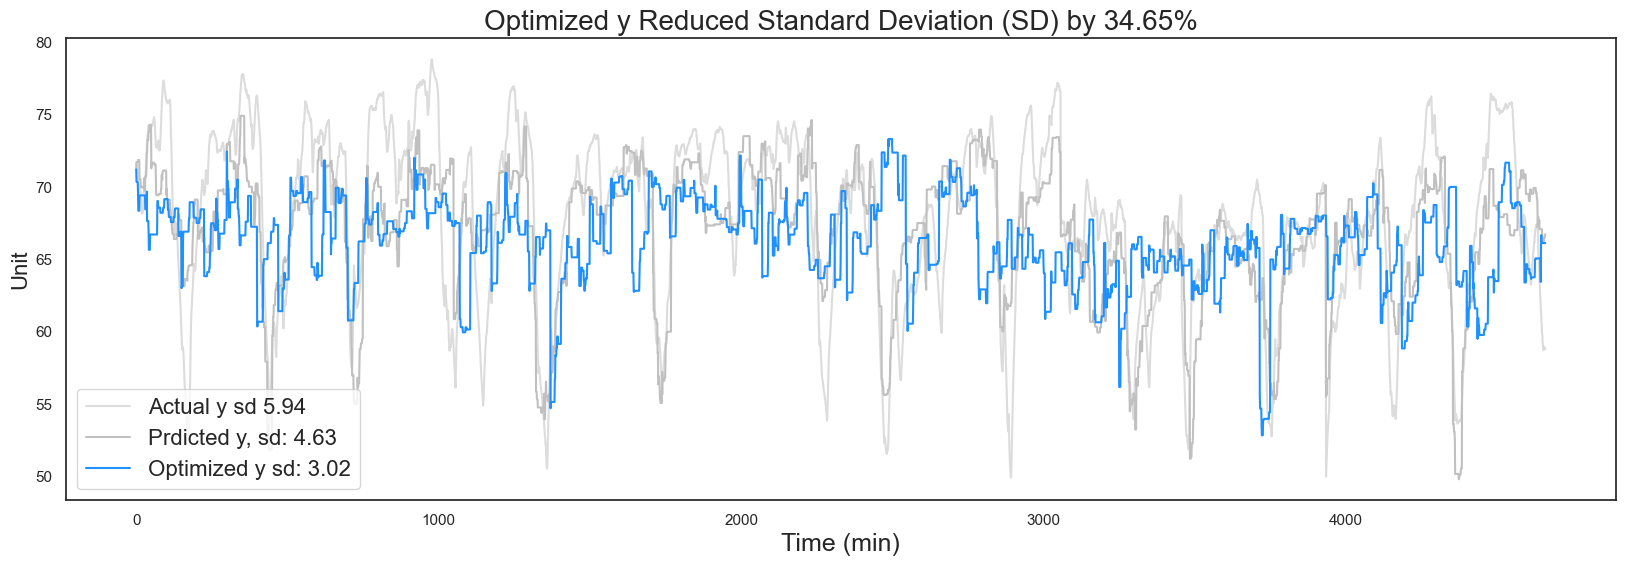

In [51]:
from random import randint
sns.set_style("white")

pyplot.figure(figsize=(20,6))
pyplot.plot(list(y_test)[0:len(l)], color='gainsboro', label=f'Actual y sd {sd_2:.2f}')
pyplot.plot(list(xgb_preds)[0:len(l)],color='silver',  label=f'Prdicted y, sd: {sd_0:.2f}')


pyplot.plot(l,color='dodgerblue', label=f'Optimized y sd: {sd_1:.2f}')
plt.xlabel('Time (min)', fontsize=18)
plt.ylabel('Unit', fontsize=16)
plt.title(f'Optimized y Reduced Standard Deviation (SD) by {percent_reduction}%',fontsize = 20)
plt.rc('legend', fontsize = 16)
pyplot.legend()
pyplot.show()

## Get Decisions

In [52]:
d = []
dates = np.unique([i.strftime('%m/%d/%Y') for i in X_test.index.date])
#dates = ['2023-05-01']
for date in dates:
    for n in range(0,6):
        time = pd.to_datetime(f"{date} 07:30:00.000") + timedelta(hours=n*2.5)
        
        d = d + sorted([i[:6] for (i,j) in list(solutions[time].keys())], key=lambda x: x[-1])
        

## Convert Decisions Into Time Series

In [53]:
from itertools import repeat

def convert_to_timeSequence(instruction_list,n):
    coil_instr = []
    for i in instruction_list:
        if np.argmax(i[:5]) == n:
            if np.argmax(i) != 4:
                coil_instr = coil_instr + list(repeat(1, 35))
            else:
                coil_instr = coil_instr + list(repeat(1, i[5]))
        elif np.argmax(i) == 4:
            coil_instr = coil_instr + list(repeat(0, i[5])) 
        else:
            coil_instr = coil_instr + list(repeat(0, 35))
        
    return coil_instr

In [54]:
Setting_A_instructions = convert_to_timeSequence(d,0)
Setting_B_instructions = convert_to_timeSequence(d,1)
Setting_C_instructions = convert_to_timeSequence(d,2)
Setting_D_instructions = convert_to_timeSequence(d,3)
Setting_E_instructions = convert_to_timeSequence(d,4)

In [55]:
Setting_A_instructions = count_continuous_ones(Setting_A_instructions)
Setting_B_instructions = count_continuous_ones(Setting_B_instructions)
Setting_C_instructions = count_continuous_ones(Setting_C_instructions)
Setting_D_instructions = count_continuous_ones(Setting_D_instructions)
Setting_E_instructions = count_continuous_ones(Setting_E_instructions)

In [56]:
X_test_orig.columns

Index(['Setting_A', 'Setting_B', 'Setting_C', 'Setting_D', 'Setting_E',
       'y_Decision_Begin', 'Time_From_Decision_Begin', 'hrOfDay', 'dayOfWeek',
       'pres_hr', 'temp_hr', 'prcp_hr', 'wdir_hr', 'wspd_hr', 'dwpt_hr',
       'coco_hr'],
      dtype='object')

In [57]:
split_date="05-09-2023"
X_test_orig=df.loc[df.index > split_date].copy()
y = list(X_test_orig['y'])
Setting_A = list(X_test_orig['Setting_A'])
Setting_B = list(X_test_orig['Setting_B'])
Setting_C = list(X_test_orig['Setting_C'])
Setting_D = list(X_test_orig['Setting_D'])
Setting_E = list(X_test_orig['Setting_E'])

In [58]:
df_instructions = pd.DataFrame(list(zip(y,l,Setting_A_instructions, Setting_B_instructions,Setting_C_instructions,Setting_D_instructions,Setting_E_instructions,
                                        Setting_A,Setting_B,Setting_C,Setting_D,Setting_E)),
                                columns =['y','Optimized_y','Setting_A_instructions', 'Setting_B_instructions','Setting_C_instructions','Setting_D_instructions','Setting_E_instructions',
                                         'Setting_A','Setting_B','Setting_C','Setting_D','Setting_E'])

## Compare Optimized Decisions with Actual Decisions

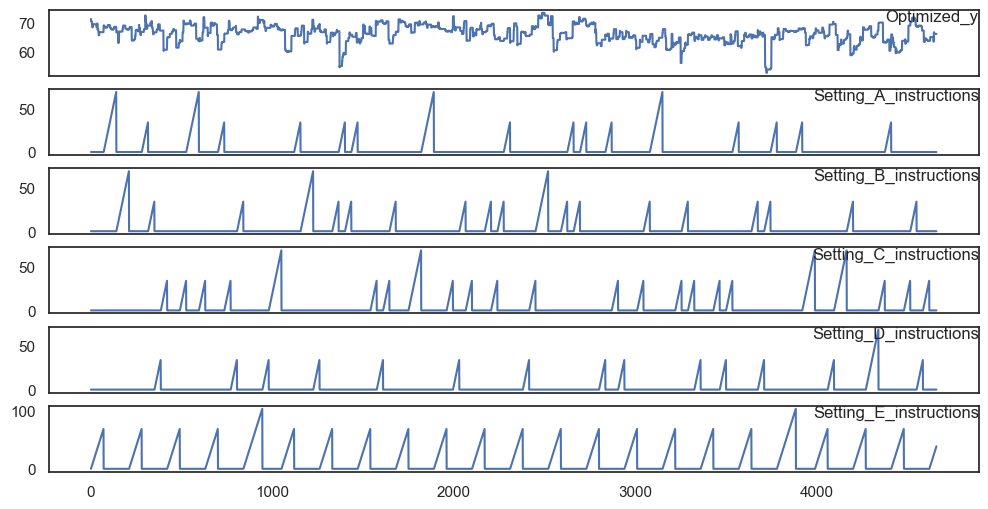

In [59]:
values = df_instructions.values
# specify columns to plot
#3,5
groups = [1,2,3,4,5,6]
i = 1
# plot each column
pyplot.figure(figsize=(12,6))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df_instructions.columns[group], y=0.7, loc='right',size = 12)
    i += 1

pyplot.show()

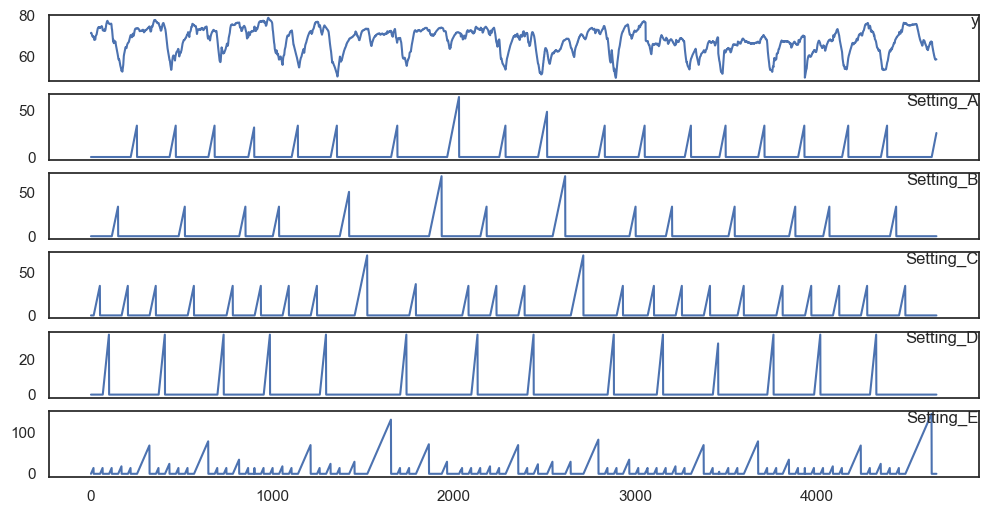

In [60]:
values = df_instructions.values
# specify columns to plot
#3,5
groups = [0,7,8,9,10,11]
i = 1
# plot each column
pyplot.figure(figsize=(12,6))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df_instructions.columns[group], y=0.7, loc='right',size = 12)
    i += 1

pyplot.show()